# Imports

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess

# pre process
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# define models
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten

# trainning
from keras import optimizers

# extension: change color
import cv2
import skimage.exposure

# Load the Data

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz



--2022-05-10 17:07:42--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 103.116.4.197
Connecting to sussex.box.com (sussex.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-10 17:07:42--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-10 17:07:42--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 185.235.236.201
Connecting to sussex.app.box.com (sussex.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

Check the data downloaded correctly

If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
confirm_checksum('test_images.npz', '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
confirm_checksum('examples.npz', 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')

In [ ]:
# Load the data using np.load
train_data = np.load('training_images.npz', allow_pickle=True)

# split training set
train_images = train_data['images']
train_pts = train_data['points']
print(train_images.shape, train_pts.shape)

# split testing set
test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

# split examples set
examples_data = np.load('examples.npz', allow_pickle=True)
examples_images = examples_data['images']
print(examples_images.shape)

(2811, 244, 244, 3) (2811, 42, 2)
(554, 244, 244, 3)
(6, 244, 244, 3)


# Functions

In [ ]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

def batch_plot(imgs, pts, nrows=3, ncols=3, mode='gray'):

  selection = np.random.choice(np.arange(imgs.shape[0]), size=(nrows*ncols), replace=False)
  fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
  print(selection)

  for idx, ax in zip(selection, axes.ravel()):
    if mode=='gray':
      img = imgs[idx, :, :, 0]
    else:
      img = imgs[idx]

    ax.set_title("pred " + str(idx))
    ax.imshow(img, cmap='gray')
    ax.plot(pts[idx][:, 0], pts[idx][:, 1], '+r')
    ax.axis('off')

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

# ———————————————

# Pre-Process

In [ ]:
# before pre-processed data
print('Training Images: ')
print('  shape: ', train_images.shape, '\n  type: ', train_images.dtype, 
      '\n  max: ', train_images.max(), '\n  min: ', train_images.min())

print()

print('Training Points: ')
print('  shape: ', train_pts.shape, '\n  type: ', train_pts.dtype, 
      '\n  max: ', train_pts.max(), '\n  min: ', train_pts.min())

Training Images: 
  shape:  (2811, 244, 244, 3) 
  type:  uint8 
  max:  255 
  min:  0

Training Points: 
  shape:  (2811, 42, 2) 
  type:  float64 
  max:  265.4624273101289 
  min:  -30.094994615013746


In [ ]:
# Divide the image data to put it in the right range and convert to floating point numbers
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255
examples_images = examples_images.astype("float32") / 255

# reshape points to fit the model
train_pts  = np.reshape(train_pts, (2811, 84)).astype("float32")

In [ ]:
# normalise points, make data in range of (-1, 1)
output_pipe = make_pipeline( MinMaxScaler(feature_range=(-1, 1)) )

train_pts = output_pipe.fit_transform(train_pts)

print(train_images.shape, train_pts.shape)

(2811, 244, 244, 3) (2811, 84)


In [ ]:
# Let about (less than) 20% of data to be the validation set
val_images = train_images[-500:]
val_pts = train_pts[-500:]
train_images = train_images[:-500]
train_pts = train_pts[:-500]

# Preparing training data in batches and shuffling it
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_pts))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset into batches
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_pts))
val_dataset = val_dataset.batch(64)

In [ ]:
# after pre-processed data
print('Training Images: ')
print('  shape: ', train_images.shape, '\n  type: ', train_images.dtype, 
      '\n  max: ', train_images.max(), '\n  min: ', train_images.min())

print()

print('Training Points: ')
print('  shape: ', train_pts.shape, '\n  type: ', train_pts.dtype, 
      '\n  max: ', train_pts.max(), '\n  min: ', train_pts.min())


Training Images: 
  shape:  (2311, 244, 244, 3) 
  type:  float32 
  max:  1.0 
  min:  0.0

Training Points: 
  shape:  (2311, 84) 
  type:  float32 
  max:  1.0000005 
  min:  -1.0000002


# --- CNN Model: 5 layers ---

## 1.define the model

In [ ]:
def build_conv0_model():
  # have the input shape same with train_image[0]
  inputs = keras.Input(shape=(244, 244, 3), name="image")
  net = inputs

  # layer 1
  # further normalisation
  net = layers.BatchNormalization(input_shape=inputs.shape)(net) 
  # he_normal aka kaiming_normal, can be better fitted with relu
  net = layers.Conv2D(filters=48, kernel_size=5, kernel_initializer='he_normal', activation='relu')(net)
  # reducing images space size to decrease the calculations amount
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  

  # layer 2
  net = layers.Conv2D(filters=60, kernel_size=5, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  

  # layer 3
  net = layers.Conv2D(filters=72, kernel_size=5, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  # flatten the layer for docking the dense layer
  net = layers.Flatten()(net)

  # layer 4
  net = layers.Dense(units=252)(net)

  # layer 5
  # fit with the shape of train_pts, 42*2=84
  net = layers.Dense(units=84)(net)

  return keras.Model(inputs=inputs, outputs=net)

conv0_model = build_conv0_model()
conv0_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 244, 244, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 244, 244, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 48)      3648      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 48)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 60)      72060     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 60)       0     

## 2.training

In [ ]:
# Training for conv0 model

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Loss
loss = 'mse'

# Metrics
metrics=["accuracy"]

# Compile
conv0_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Fit
result_conv0 = conv0_model.fit(train_dataset, batch_size=32, epochs=200, validation_data=val_dataset)

Epoch 1/200
37/37 [==============================] - 24s 279ms/step - loss: 4.8252 - accuracy: 0.4435 - val_loss: 0.0834 - val_accuracy: 0.5920
Epoch 2/200
37/37 [==============================] - 9s 229ms/step - loss: 0.0466 - accuracy: 0.8235 - val_loss: 0.0759 - val_accuracy: 0.8180
Epoch 3/200
37/37 [==============================] - 8s 230ms/step - loss: 0.0366 - accuracy: 0.8286 - val_loss: 0.0544 - val_accuracy: 0.8300
Epoch 4/200
37/37 [==============================] - 9s 230ms/step - loss: 0.0313 - accuracy: 0.8295 - val_loss: 0.0512 - val_accuracy: 0.8340
Epoch 5/200
37/37 [==============================] - 9s 231ms/step - loss: 0.0284 - accuracy: 0.8312 - val_loss: 0.0370 - val_accuracy: 0.8060
Epoch 6/200
37/37 [==============================] - 9s 231ms/step - loss: 0.0470 - accuracy: 0.8040 - val_loss: 0.0739 - val_accuracy: 0.8060
Epoch 7/200
37/37 [==============================] - 9s 231ms/step - loss: 0.0491 - accuracy: 0.8109 - val_loss: 0.0409 - val_accuracy: 0.808

## 3.prediction

### testing set

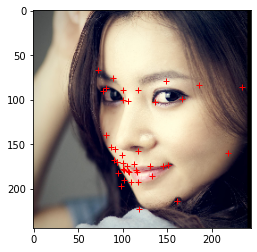

In [ ]:
# use embedded function to predict test images
conv0_test = conv0_model.predict(test_images)

# change data back to the original shape
conv0_test = output_pipe.inverse_transform(conv0_test)
conv0_test = np.reshape(conv0_test, (-1, 42, 2))

# plot a single image
visualise_pts(test_images[324], conv0_test[324])

[155  23 259 551 272 156 177 363  72]


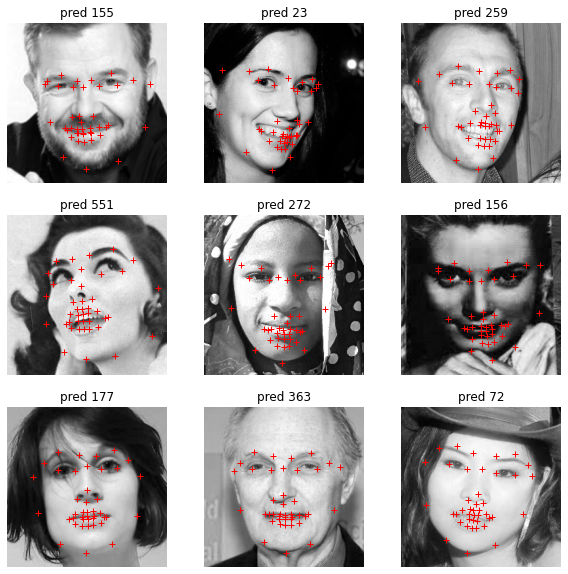

In [ ]:
batch_plot(test_images, conv0_test) #287

### examples plotting

[4 5 0 3 2 1]


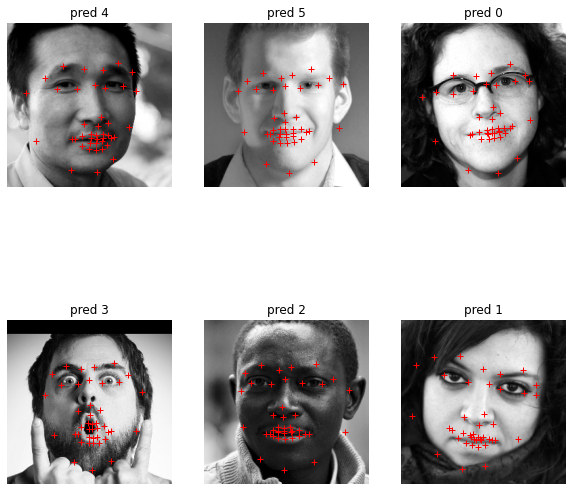

In [ ]:
# use embedded function to predict example images
conv0_ex = conv0_model.predict(examples_images)

# change data back to the original shape
conv0_ex = output_pipe.inverse_transform(conv0_ex)
conv0_ex = np.reshape(conv0_ex, (-1, 42, 2))

batch_plot(examples_images, conv0_ex, nrows=2, ncols=3)

## 4.analysing data

In [ ]:
# predict and process the prediction of validation set
conv0_val = conv0_model.predict(val_images)
conv0_val = output_pipe.inverse_transform(conv0_val)
conv0_val = np.reshape(conv0_val, (-1, 42, 2))

# process ground truth of validation set
gt_val = val_pts.copy()
gt_val = output_pipe.inverse_transform(gt_val)
gt_val = np.reshape(gt_val, (-1, 42, 2))

print('Mean of euclid dist of model 1 is ', np.mean(euclid_dist(conv0_val, gt_val)) )

Mean of euclid dist of model 1 is  7.5926623


# --- CNN Model: 8 Layers ---

Add three more layers than the previous one

## 1.define the model

In [ ]:
def build_conv1_model():
  # have the input shape same with train_image[0]
  inputs = keras.Input(shape=(244, 244, 3), name="image")
  net = inputs

  # layer 1
  # further normalisation
  net = layers.BatchNormalization(input_shape=inputs.shape)(net) 
  # he_normal aka kaiming_normal, can be better fitted with relu
  net = layers.Conv2D(filters=24, kernel_size=5, kernel_initializer='he_normal', activation='relu')(net)
  # reducing images space size to decrease the calculations amount
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)

  # layer 2
  net = layers.Conv2D(filters=36, kernel_size=5, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)

  # layer 3
  net = layers.Conv2D(filters=48, kernel_size=5, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)

  # layer 4
  net = layers.Conv2D(filters=60, kernel_size=3, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)

  # layer 5
  net = layers.Conv2D(filters=72, kernel_size=3, activation='relu')(net)
  # flatten the layer for docking the dense layer
  net = layers.Flatten()(net)

  # layer 6
  net = layers.Dense(units=500, activation='relu')(net)

  # layer 7
  net = layers.Dense(units=200, activation='relu')(net)

  # layer 8
  # fit with the shape of train_pts, 42*2=84
  net = layers.Dense(units=84)(net)

  return keras.Model(inputs=inputs, outputs=net)


conv1_model = build_conv1_model()
conv1_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 244, 244, 3)]     0         
                                                                 
 batch_normalization_1 (Batc  (None, 244, 244, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 24)      1824      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 24)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 116, 116, 36)      21636     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 58, 36)       0   

## 2.training

In [ ]:
# Training for convolutional model

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Loss
loss = 'mse'

# Metrics
metrics=["accuracy"]

# Compile
conv1_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Fit
result_conv1 = conv1_model.fit(train_dataset, batch_size=64, epochs=200, validation_data=val_dataset)

Epoch 1/200
37/37 [==============================] - 9s 185ms/step - loss: 0.0640 - accuracy: 0.7776 - val_loss: 0.0630 - val_accuracy: 0.8300
Epoch 2/200
37/37 [==============================] - 6s 156ms/step - loss: 0.0294 - accuracy: 0.8425 - val_loss: 0.0436 - val_accuracy: 0.8340
Epoch 3/200
37/37 [==============================] - 6s 157ms/step - loss: 0.0203 - accuracy: 0.8494 - val_loss: 0.0323 - val_accuracy: 0.8460
Epoch 4/200
37/37 [==============================] - 6s 157ms/step - loss: 0.0161 - accuracy: 0.8490 - val_loss: 0.0202 - val_accuracy: 0.8460
Epoch 5/200
37/37 [==============================] - 6s 156ms/step - loss: 0.0139 - accuracy: 0.8559 - val_loss: 0.0174 - val_accuracy: 0.8620
Epoch 6/200
37/37 [==============================] - 6s 156ms/step - loss: 0.0123 - accuracy: 0.8602 - val_loss: 0.0138 - val_accuracy: 0.8620
Epoch 7/200
37/37 [==============================] - 6s 156ms/step - loss: 0.0107 - accuracy: 0.8633 - val_loss: 0.0139 - val_accuracy: 0.8580

## 3.prediction

### testing set

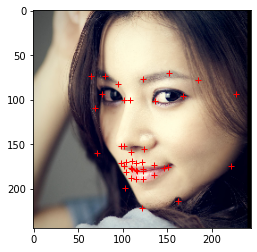

In [ ]:
# use embedded function to predict test images
conv1_test = conv1_model.predict(test_images)

# change data back to the original shape
conv1_test = output_pipe.inverse_transform(conv1_test)
conv1_test = np.reshape(conv1_test, (-1, 42, 2))

# plot a single image
visualise_pts(test_images[324], conv1_test[324])

[131 493 104 484 163 267 226 534  71]


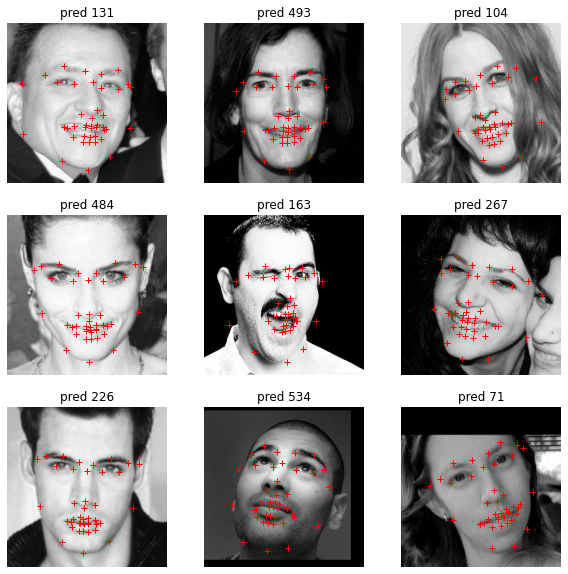

In [ ]:
batch_plot(test_images, conv1_test) #287

### example plotting

[0 2 3 5 4 1]


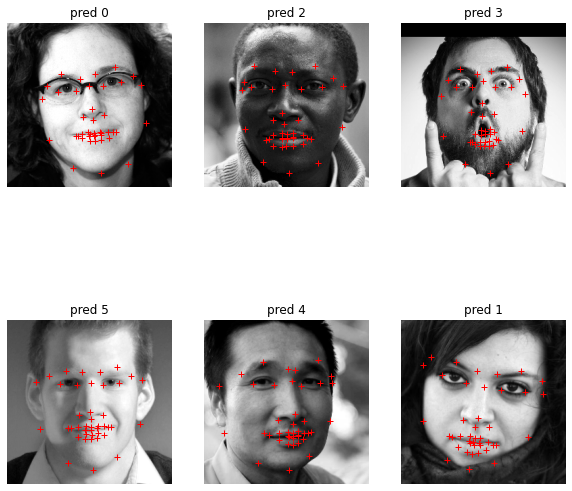

In [ ]:
# use embedded function to predict example images
conv1_ex = conv1_model.predict(examples_images)

# change data back to the original shape
conv1_ex = output_pipe.inverse_transform(conv1_ex)
conv1_ex = np.reshape(conv1_ex, (-1, 42, 2))

batch_plot(examples_images, conv1_ex, nrows=2, ncols=3)

## 4.analysing data

In [ ]:
# predict and process the prediction of validation set
conv1_val = conv1_model.predict(val_images)
conv1_val = output_pipe.inverse_transform(conv1_val)
conv1_val = np.reshape(conv1_val, (-1, 42, 2))

# process ground truth of validation set
gt_val = val_pts.copy()
gt_val = output_pipe.inverse_transform(gt_val)
gt_val = np.reshape(gt_val, (-1, 42, 2))

print('Mean of euclid dist of model 2 is ', np.mean(euclid_dist(conv1_val, gt_val)) )

Mean of euclid dist of model 2 is  4.775454


# --- CNN Model: final version ---

add overfitting process in each convolutional layer

## 1.define the model

In [ ]:
def build_conv_model():
  # have the input shape same with train_image[0]
  inputs = keras.Input(shape=(244, 244, 3), name="image")
  net = inputs

  # layer 1
  # further normalisation
  net = layers.BatchNormalization(input_shape=inputs.shape)(net) 
  # he_normal aka kaiming_normal, can be better fitted with relu
  net = layers.Conv2D(filters=24, kernel_size=5, kernel_initializer='he_normal', activation='relu')(net)
  # reducing images space size to decrease the calculations amount
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  # prevent over-fitting
  net = layers.Dropout(0.2)(net)

  # layer 2
  net = layers.Conv2D(filters=36, kernel_size=5, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  net = layers.Dropout(0.2)(net)

  # layer 3
  net = layers.Conv2D(filters=48, kernel_size=5, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  net = layers.Dropout(0.2)(net)

  # layer 4
  net = layers.Conv2D(filters=60, kernel_size=3, activation='relu')(net)
  net = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(net)
  net = layers.Dropout(0.2)(net)

  # layer 5
  net = layers.Conv2D(filters=72, kernel_size=3, activation='relu')(net)
  # flatten the layer for docking the dense layer
  net = layers.Flatten()(net)

  # layer 6
  net = layers.Dense(units=500, activation='relu')(net)

  # layer 7
  net = layers.Dense(units=200, activation='relu')(net)

  # layer 8
  # fit with the shape of train_pts, 42*2=84
  net = layers.Dense(units=84)(net)

  return keras.Model(inputs=inputs, outputs=net)


conv_model = build_conv_model()
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 244, 244, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 244, 244, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 24)      1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 24)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 120, 120, 24)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 36)      21636 

## 2.trainning

In [ ]:
# Training for convolutional model

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.95, nesterov=True)

# Loss
loss = 'mse'
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# loss = "sparse_categorical_crossentropy"

# Metrics
metrics=["accuracy"]
# metrics=["sparse_categorical_accuracy"]

# Compile
conv_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Fit
# result_conv = conv_model.fit(train_images, train_pts, batch_size=64, epochs=200, validation_split=0.2, shuffle=True)
result_conv = conv_model.fit(train_dataset, batch_size=64, epochs=200, validation_data=val_dataset)

Epoch 1/200
37/37 [==============================] - 19s 193ms/step - loss: 0.0849 - accuracy: 0.7542 - val_loss: 0.0754 - val_accuracy: 0.8300
Epoch 2/200
37/37 [==============================] - 6s 160ms/step - loss: 0.0613 - accuracy: 0.8416 - val_loss: 0.0705 - val_accuracy: 0.8300
Epoch 3/200
37/37 [==============================] - 6s 160ms/step - loss: 0.0461 - accuracy: 0.8412 - val_loss: 0.0593 - val_accuracy: 0.8340
Epoch 4/200
37/37 [==============================] - 7s 179ms/step - loss: 0.0304 - accuracy: 0.8473 - val_loss: 0.0438 - val_accuracy: 0.8360
Epoch 5/200
37/37 [==============================] - 6s 160ms/step - loss: 0.0243 - accuracy: 0.8520 - val_loss: 0.0386 - val_accuracy: 0.8360
Epoch 6/200
37/37 [==============================] - 6s 160ms/step - loss: 0.0217 - accuracy: 0.8503 - val_loss: 0.0282 - val_accuracy: 0.8520
Epoch 7/200
37/37 [==============================] - 6s 159ms/step - loss: 0.0193 - accuracy: 0.8533 - val_loss: 0.0221 - val_accuracy: 0.856

## 3.prediction

### testing set

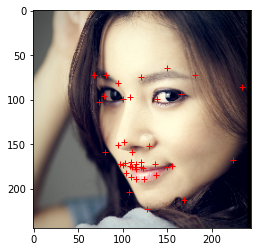

In [ ]:
# use embedded function to predict test images
conv_test = conv_model.predict(test_images)

# change data back to the original shape
conv_test = output_pipe.inverse_transform(conv_test)
conv_test = np.reshape(conv_test, (-1, 42, 2))

# plot a single image
visualise_pts(test_images[324], conv_test[324])

[  9 477 446 234 437 501 210 389 284]


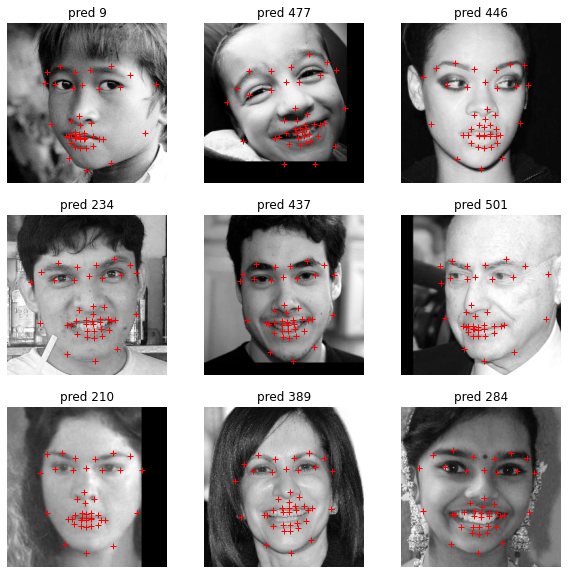

In [ ]:
batch_plot(test_images, conv_test) #287

### examples plotting

[2 1 3 4 0 5]


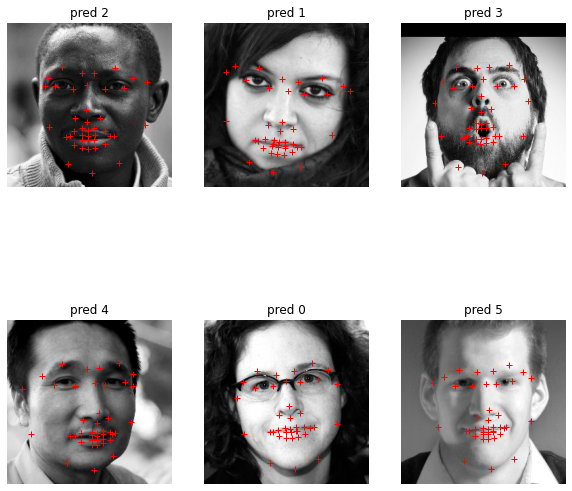

In [ ]:
# use embedded function to predict example images
conv_ex = conv_model.predict(examples_images)

# change data back to the original shape
conv_ex = output_pipe.inverse_transform(conv_ex)
conv_ex = np.reshape(conv_ex, (-1, 42, 2))

batch_plot(examples_images, conv_ex, nrows=2, ncols=3)

## 4.analysing data

In [ ]:
# predict and process the prediction of validation set
conv_val = conv_model.predict(val_images)
conv_val = output_pipe.inverse_transform(conv_val)
conv_val = np.reshape(conv_val, (-1, 42, 2))

# process ground truth of validation set
gt_val = val_pts.copy()
gt_val = output_pipe.inverse_transform(gt_val)
gt_val = np.reshape(gt_val, (-1, 42, 2))

print('Mean of euclid dist of model 3 is ', np.mean(euclid_dist(conv_val, gt_val)) )

Mean of euclid dist of model 3 is  4.519407


# Extenstion: Change Color of Lips/Eyes

In [ ]:
def get_eye_pts(point1, point2):
  # get the x and y center of two points
  x_center = (point1[0:1][0]+point2[0:1][0])/2
  y_center = (point1[1:2][0]+point2[1:2][0])/2

  # calc the y of extra points
  y_top = y_center - (x_center - point1[0:1][0])/2
  y_bottom = y_center + (x_center - point1[0:1][0])/4

  # combine the x and y
  pt_top = [x_center, y_top]
  pt_bottom = [x_center, y_bottom]

  result = [[point1[0:1][0], point1[1:2][0]], pt_top, [point2[0:1][0], point2[1:2][0]], pt_bottom]
  result = np.asarray(result)
  result = result.astype(np.float32)
  return result

In [ ]:
def modify_color(img, pts, lip_rgb, l_eye_rgb, r_eye_rgb, show_mask=False):
  # get the img sample
  img_sample = img.astype(np.float64)
  pts_lip = pts[22:]
  pts_left_eye = get_eye_pts(pts[18], pts[19])
  pts_right_eye = get_eye_pts(pts[20], pts[21])

  # set up the mask
  mask = np.zeros((244, 244, 3))
  mask = cv2.fillPoly(mask, np.int32([pts_lip]), lip_rgb)
  mask = cv2.fillPoly(mask, np.int32([pts_left_eye]), l_eye_rgb)
  mask = cv2.fillPoly(mask, np.int32([pts_right_eye]), r_eye_rgb)
  if show_mask == True:
    plt.title('fillpoly')
    plt.imshow(mask)
    plt.show()

  # bitwise
  cv2.bitwise_and(img_sample, mask)
  if show_mask == True:
    plt.title('bitwise')
    plt.imshow(mask)
    plt.show()

  # erosion(opening) and dilation(closing)
  kernel =(5,5)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
  if show_mask == True:
    plt.title('morphology')
    plt.imshow(mask)
    plt.show()

  # Gaussian Blur
  mask = cv2.GaussianBlur(mask, (15,15), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)
  mask = skimage.exposure.rescale_intensity(mask, in_range=(0,255), out_range=(0,1)).astype(np.float64)
  if show_mask == True:
    plt.title('Gaussian Blur')
    plt.imshow(mask)
    plt.show()

  # combine the mask and image
  final_img = cv2.addWeighted(img_sample, 1, mask, 0.5, 0)

  return final_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


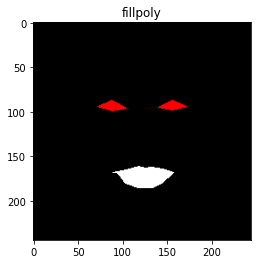

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


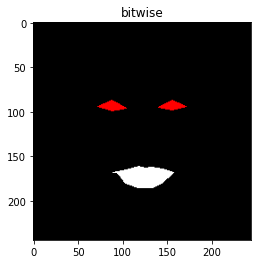

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


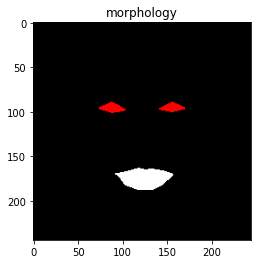

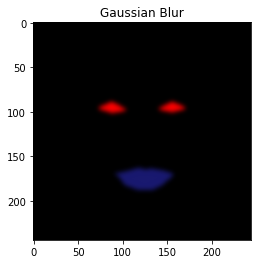

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


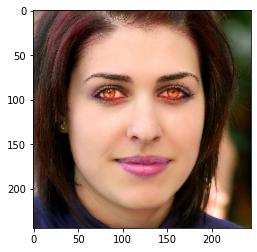

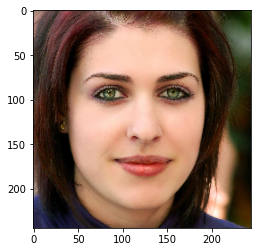

In [ ]:
# plot a single result
idx=8
a = modify_color(train_images[idx], train_pts[idx], [25,25,112], [255,0,0], [255,0,0], show_mask=True)

plt.imshow(a)
plt.show()
plt.imshow(train_images[idx])
plt.show()

In [ ]:
# batch modifying
all_modified = [modify_color(test_images[i],conv_test[i],[25,25,112],[255,0,0],[255,0,0]) for i in range(554)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


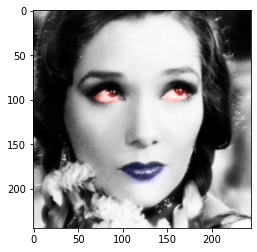

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


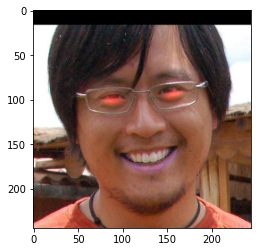

In [ ]:
plt.imshow(all_modified[247])
plt.show()
plt.imshow(all_modified[97])
plt.show()

# Save as .csv

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [ ]:
# save prediction data of CNN model: final version
save_as_csv(conv_test)